In this model we are going to use LSTM algorithm to do the prediction

# Apple stock 'Close' value prediction (5-year-data)

In [1]:
from pandas_datareader import data
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pandas import datetime
import math, time
import itertools
from sklearn import preprocessing
import datetime
from datetime import date 
from operator import itemgetter
from sklearn.metrics import mean_squared_error
from math import sqrt
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.recurrent import LSTM

Using TensorFlow backend.


## Loading Apple stock data from "finance.yahoo.com"

This is how the stock dataset looks like in csv file
#### AAPL.scv
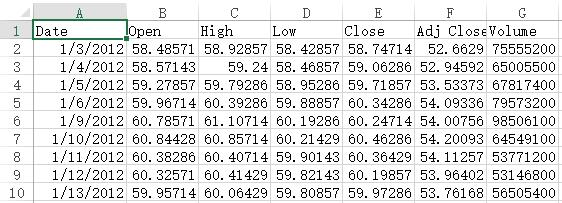
In this dataset we are going to use three instance "Open""High""Adj Close" for prediction. There are 1484 rows of data in total. The dataset is the same as in part 1

In [2]:
start=date(2012,1,3)
end=date(2017,11,21)
apple=data.DataReader("AAPL","yahoo",start,end)
df = pd.DataFrame(apple)
df.drop(df.columns[[2,3,5]], axis=1, inplace=True) 

df.head()

,Open,High,Adj Close
Date,,,
2012-01-03,58.485714,58.928570,52.662899
2012-01-04,58.571430,59.240002,52.945919
2012-01-05,59.278572,59.792858,53.533730
2012-01-06,59.967144,60.392857,54.093361
2012-01-09,60.785713,61.107143,54.007557


## Prepare the data for further uses

In [3]:
df['High'] = df['High'] / 1000
df['Open'] = df['Open'] / 1000
df['Adj Close'] = df['Adj Close'] / 1000
df.head(5)

,Open,High,Adj Close
Date,,,
2012-01-03,0.058486,0.058929,0.052663
2012-01-04,0.058571,0.059240,0.052946
2012-01-05,0.059279,0.059793,0.053534
2012-01-06,0.059967,0.060393,0.054093
2012-01-09,0.060786,0.061107,0.054008


## Pre-processing data

In [4]:
def load_data(stock, seq_len):
    amount_of_features = len(stock.columns)
    data = stock.as_matrix() #pd.DataFrame(stock)
    sequence_length = seq_len + 1
    result = []
    for index in range(len(data) - sequence_length):
        result.append(data[index: index + sequence_length])

    result = np.array(result)
    row = round(0.9 * result.shape[0])
    train = result[:int(row), :]
    x_train = train[:, :-1]
    y_train = train[:, -1][:,-1]
    x_test = result[int(row):, :-1]
    y_test = result[int(row):, -1][:,-1]

    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], amount_of_features))
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], amount_of_features))  

    return [x_train, y_train, x_test, y_test]


## Building model functions

recurrent neural networks (RNN), a class of nets taht can predict the future. They can analyze time series data such as tock prices, and tell youwhen to buy or sell. a recurrent neural network looks very much like a feedforward neural network, except it also has connections pointing backward. 
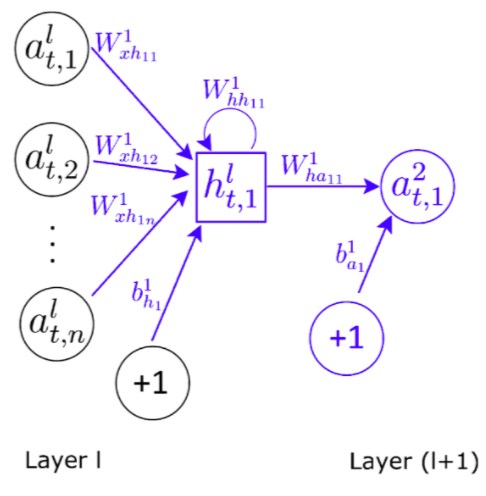
each recurrent neuron has two sets of weights: one for the unputs x(t) and the other for the outputs of the previous time step, y(t-1), Let's call these weights vectors Wx and Wy. The output of a single recurrent neuron can be computed pretty much as you might expect.Just like for feedforward neural networks, we can compute a whole layer's output in one shot for a whole mini-batch using a vetorized form of the previous equation，as the neuron receive the output from the last step neuron so we can say that the neuron has a form of memory.A part of a neural network that preserves some state across time steps is called a memory cell. A singe recurrent neuron, or a layer of recurrent neurons , is a very basic cell.An RNN can simultaneously take a sequence of inputs and prodece a sequence of outputs.
To train an RNN, the trick is to unroll it through time and then simply use regular backpropagation. This strategy is called backpropagation through time (BPTT)
If BUILD A very deep RNN, it may end up overfitting the training set, To prevent that, a common technique is to apply dropout,simply add a dropout layer before of after the RNN as usual

LSTM Cell: 
    with out looking at the inside of the LSTM Cell seem exactly like a regular cell, except that its state is split in two vectors: h(t) and c(t), h(t) as shot-term , c(t) as long-term 
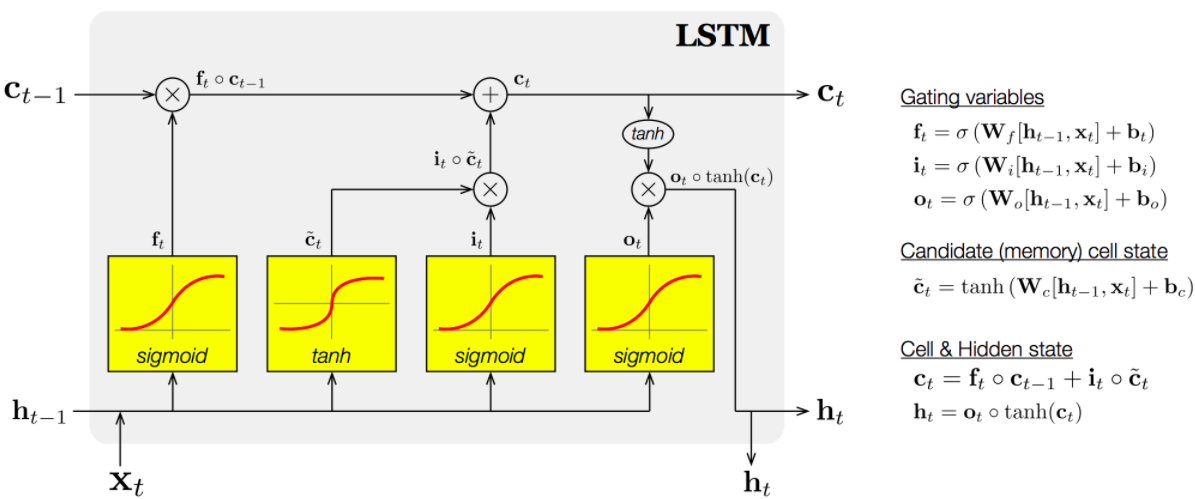
    The network can learn what to store in the long-term state, what to throw away, and what to read from it. As teh long-term state c(t-1) traverses the network from left to rigth, you can see that it first goes through a gorget gate, dropping some memories, and then it adds new memories via the addition operation. The result c(t) is sent straigth out, without any further transformation, So, at each time step, some memories are dropped and some memories are added. Moreover, after the addition operation, the loong-term state is copied and passed through the tanh function, and then the result is filtered by the output gate, Theis produces the short-term state h(t). 
    the main layer is the outputs c(t): it realize the relationship between x(t) and previous (shot-term) h(t-1), in order to decide which part of the h(t-1) should be memory
    the forget gate f(t):decide which part of the long-term state should be erased 
    the input gate i(t): decide which part of c(t) should be add to the long term 
    the output gate o(t): control which part of the longterm should be read and get y(t)

In [5]:
def build_model(layers):
        d = 0.2
        model = Sequential()
        model.add(LSTM(128, input_shape=(layers[1], layers[0]), return_sequences=True))
        model.add(Dropout(d))
        model.add(LSTM(64, input_shape=(layers[1], layers[0]), return_sequences=False))
        model.add(Dropout(d))
        model.add(Dense(16,kernel_initializer='uniform',activation='tanh'))        
        model.add(Dense(1,kernel_initializer='uniform',activation='tanh'))
        model.compile(loss='mse',optimizer='adam',metrics=['accuracy'])
        return model

In LSTM there are three gates (in, out, forget) need use gating function to control the output. The output value is between 0 and 1 which means the gate can either let no flow or complete flow of information to go through. Therefore we need a function whose second derivative can sustain for a long range before going to zero. So “Tanh” seems to be a good choice for this project. We did try “Relu” but the result is slightly worse than “Tanh”.

Tanh:

Mathematical expression: tanh(z) = [exp(z) - exp(-z)] / [exp(z) + exp(-z)]

1st order derivative: tanh'(z) = 1 - ([exp(z) - exp(-z)] / [exp(z) + exp(-z)])^2 = 1 - tanh^2(z)

Advantages:
(1) Often found to converge faster in practice
(2) Gradient computation is less expensive

ReLU:

Mathematical expression: relu(z) = max(z, 0)

1st order derivative: relu'(z) = 1 if z > 0; 0 otherwise

Advantages:
(1) Does not saturate even for large values of z
(2) Found much success in computer vision applications


## Setting X and Y for training and testing

In [6]:
window = 5
X_train, y_train, X_test, y_test = load_data(df[::-1], window)
print("X_train", X_train.shape)
print("y_train", y_train.shape)
print("X_test", X_test.shape)
print("y_test", y_test.shape)

X_train (1329, 5, 3)
y_train (1329,)
X_test (148, 5, 3)
y_test (148,)


## Loading the model sequence structure

In [7]:
model = build_model([3,window,1])

## Executing the model & RMS/RMSE results

In [8]:
model.fit(
    X_train,
    y_train,
    batch_size=1500,
    epochs=4500,
    validation_split=0.1,
    verbose=0)

## Predictions vs Real results

In [9]:
p = model.predict(X_test)
perdiction=[]
for u in range(2,len(y_test)):
    
    pr = p[u][0]
    perdiction.append(pr)
#print(perdiction)   

### Apple stock 'Close' value prediction(5-year-data)

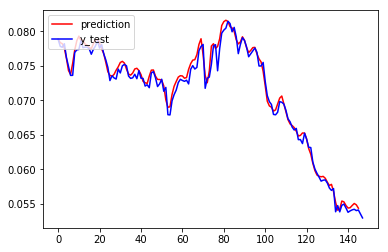

In [11]:
import matplotlib.pyplot as plt2

plt2.plot(perdiction,color='red', label='prediction')
plt2.plot(y_test,color='blue', label='y_test')

plt2.legend(loc='upper left')
plt2.show()

## Discussion

### Alibaba stock 'Close' value prediction(2-year-data)
First we tried our algorithm on other company stocks. Such as Alibaba and Boeing. Since Alibaba only has about 2 years of time on the stock market, so the amount of data is much less than Boeing---A company has a very long time on the stock market. We were trying to see the performance of our algorithm on a relative small data set. It turns out the result is not very accurate. It seems has a time shift error on our prediction. To compensate that error we tried to increase the iteration of training process. We increased our batch_size=512 and epochs=500 to batch_size=1000 and epochs=2000 and batch_size=1500 and epochs=4500. The prediction start to close to the test results when we increases the iteration. Therefore for the better performance we decided our batch_size=1500 and epochs=4500.
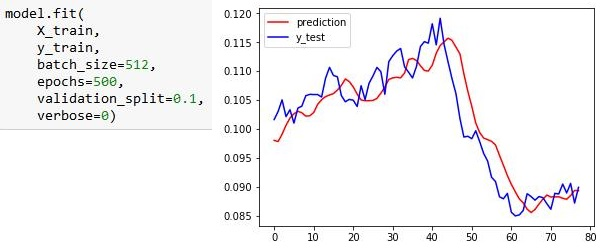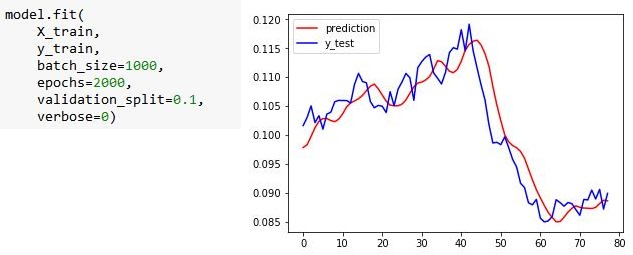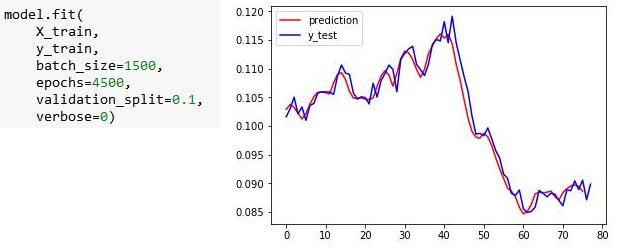

### Boeing stock 'Close' value prediction(5-year-data)
We used the same parameter on a larger data set---Boeing stock. The result turns out quite accurate. With the test result of Apple stock, it proves our algorithm works for this kind stock prediction.
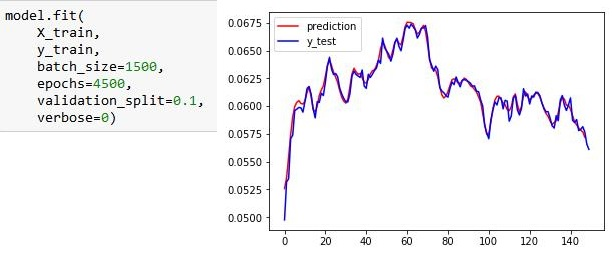

### Problem
Since when we use LSTM to predict the stock price, each single price prediction is related to all the past data which means in each iteration the calculation process is enormous compare to MLP and Linear regression. Therefore the processing time takes very long. In our case, it takes roughly 4 minuets for the whole prediction.  

## Summary
After running three models, LSTM is more practical for the stock price prediction. Because it can store past data information to predict the price. However other two models---MLP and Linear regression can only apply the latest date point attributes for the prediction classification, the output is not relevant to the past data. And since whenever LSTM run a prediction, it went through all the past data and preserve partial information for the prediction. Furthermore it can avoid problem coming up during running long sequences training in RNN. 

To train an RNN on long sequences, you will need to run it over many times steps, making the unrolled RNN a very deep network. Just like any deep neural network it may suffer from the vanishing gradients problem and take forever to train. Besides the long training time, a second problem faced by long-running RNNs is the fact that the memory of the first inputs gradually fades away.

For conclusion, we believe the LSTM algorithm is the best fit for the stock price prediction.
